In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:

varinfo.HX_m = dict(bins=(0,300,30))
varinfo.H1_m = dict(bins=(0,300,30))
varinfo.H2_m = dict(bins=(0,300,30))

varinfo.Y_m = dict(bins=(0,1500,30))
varinfo.X_m = dict(bins=(375,1500,31))

In [5]:
fc.sixb = fc.FileCollection('/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_4b/')
f_signal = np.array([ f'{d}/ntuple.root' for d in fc.sixb.Official_NMSSM.ls if d.endswith('pythia8') ])

mass_points = [
    (500,250)
    # (750, 250),
    # (800, 300)
]

re_mxmy = re.compile(r'.*MX-(\d+)_MY-(\d+).*')
def get_mxmy(fname):
    m = re_mxmy.match(fname)
    if m:
        return int(m.group(1)), int(m.group(2))
    return None

f_signal = [ f for f in f_signal if get_mxmy(f) in mass_points ]

In [6]:
f_signal

['/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_4b/Official_NMSSM/NMSSM_XToYHTo6B_MX-500_MY-250_TuneCP5_13TeV-madgraph-pythia8/ntuple.root']

In [7]:
signal = ObjIter([Tree([f], report=False) for f in tqdm(f_signal)])

100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


In [8]:
f_qcd = fc.sixb.QCD_B_List
f_tt = list(map(lambda f : f.replace('ntuple_0','ntuple'), fc.sixb.TTJets))

bkg = ObjIter([Tree(f_qcd), Tree(f_tt)])

100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


In [9]:
modelpath = '/eos/uscms/store/user/ekoenig/weaver/models/exp_sixb_official/feynnet_ranker_6b/20230731_7d266883bbfb88fe4e226783a7d1c9db_ranger_lr0.0047_batch2000_withbkg/'

load_feynnet = sixb.f_load_feynnet_assignment(model=modelpath, onnx=False)

(signal+bkg).apply(load_feynnet, report=True)
(signal+bkg).apply(sixb.assign)

f_load_feynnet_assignment: 100%|██████████| 3/3 [00:06<00:00,  2.16s/it]


[None, None, None]

In [10]:
signal.apply(sixb.load_true_assignment)

[None]

In [11]:
bdt = sixb.bdt.get_ar_bdt()

In [12]:
tree = signal[0]


print('total raw:', len(tree))
print('ar raw:   ', ak.sum(bdt.mask(tree)))
print('ar sr raw:', ak.sum(bdt.sr(tree)))
print('ar cr raw:', ak.sum(bdt.cr(tree)))


total raw: 51512
ar raw:    12795
ar sr raw: 5419
ar cr raw: 7376


In [13]:
bdt.print_yields(tree)

       --- ABCD MX_500_MY_250 Yields ---        
Total: 9.64e-03 (24.84%)                        
SR   : 4.08e-03 (10.52%)                        
CR   : 5.56e-03 (14.32%)                        
------------------------------------------------
|           A          |           B           |
|       3.42e-03       |       6.69e-04        |
|        8.80%         |        1.72%          |
------------------------------------------------
|           C          |           D           |
|       4.31e-03       |       1.25e-03        |
|        11.11%        |        3.21%          |
------------------------------------------------


In [14]:
import pickle as pkl

bkg_model = '/uscms_data/d3/ekoenig/8BAnalysis/studies/eightbStudies/scripts/sixb_feynnet/ranker/bkg_model_histos.pkl'
with open(bkg_model, 'rb') as f:
    bkg_model_histos = pkl.load(f)

100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


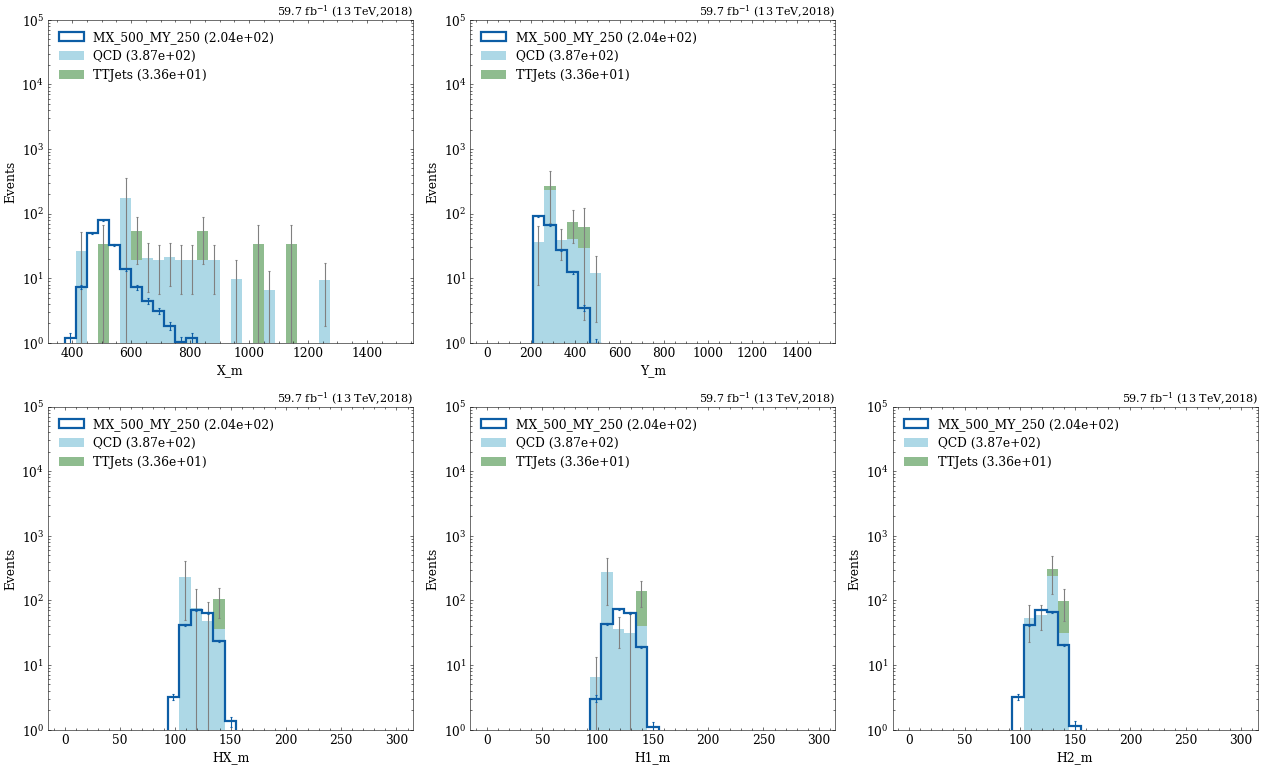

In [15]:
histos = obj_store()
study.quick(
    signal+bkg,
    masks=bdt.a,
    varlist=['X_m','Y_m',None,'HX_m','H1_m','H2_m'],
    store=histos,
    log=True, ylim=(1, 1e5),
    legend=True
)

In [16]:
h_sigs = [ h for h in histos[0] if not isinstance(h, Stack) ]

In [17]:
lim_models = ObjIter([ Model(h_sig, bkg_model_histos['X_m']) for h_sig in h_sigs ])

In [18]:
get_upperlimits = f_upperlimit(poi=np.linspace(0.1, 5, 50))
out = lim_models.apply(get_upperlimits, report=True)

f_upperlimit: 100%|██████████| 1/1 [00:08<00:00,  8.19s/it]


In [19]:
lim_models.h_sig.set_label('exp_lim')

[None]

In [20]:
out[0][1]

[DeviceArray(0.0704634, dtype=float64),
 DeviceArray(0.09559997, dtype=float64),
 DeviceArray(0.13452623, dtype=float64),
 DeviceArray(0.1904852, dtype=float64),
 DeviceArray(0.26122784, dtype=float64)]

[(<Figure size 650x650 with 1 Axes>, <AxesSubplot:ylabel='Events'>)]

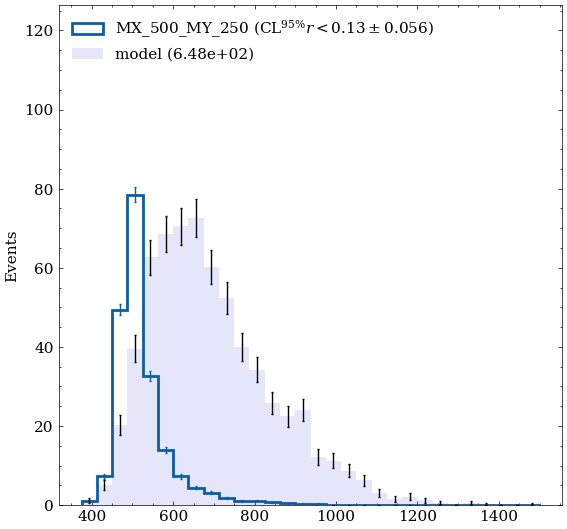

In [21]:
lim_models.apply( lambda m : plot_model(m, legend=True))

In [23]:
f_suzs_signal = '/uscms/home/srosenzw/nobackup/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/sixb/plots/feynnet/20230731_7d266883bbfb88fe4e226783a7d1c9db_ranger_lr0.0047_batch2000_withbkg/Summer2018UL/concentric/root_files/signal_500_250.root'
f_suzs_signal = ut.open(f_suzs_signal)
h_suzs_signal = Histo.from_th1d(f_suzs_signal['data'], histtype='step', is_signal='(500,250)')

In [24]:
f_suzs_data = '/uscms/home/srosenzw/nobackup/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/sixb/plots/feynnet/20230731_7d266883bbfb88fe4e226783a7d1c9db_ranger_lr0.0047_batch2000_withbkg/Summer2018UL/concentric/root_files/gnn_data_asr_model.root'
f_suzs_data = ut.open(f_suzs_data)
h_suzs_data = Histo.from_th1d(f_suzs_data['data'], color='lightgrey')

In [25]:
suzs_model = Model(h_suzs_signal, h_suzs_data)
out = get_upperlimits(suzs_model)
suzs_model.h_sig.set_label('exp_lim')

In [26]:
out[1]

[DeviceArray(0.07707524, dtype=float64),
 DeviceArray(0.10146645, dtype=float64),
 DeviceArray(0.14141761, dtype=float64),
 DeviceArray(0.1984369, dtype=float64),
 DeviceArray(0.26769783, dtype=float64)]

(<Figure size 650x650 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

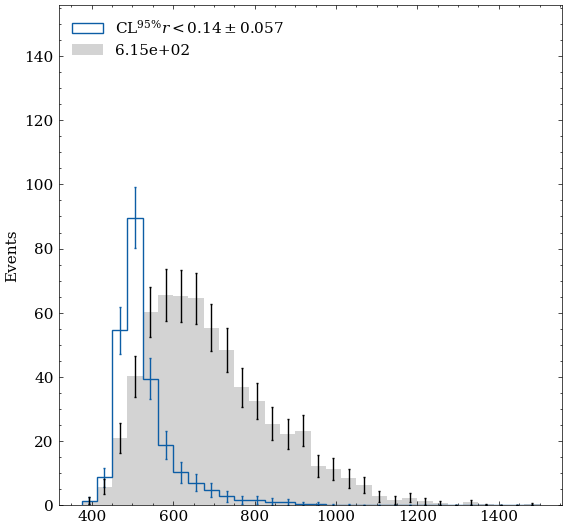

In [94]:
plot_model(suzs_model, legend=True)

In [39]:
def get_stats(h_data, h_signal, poi=np.linspace(0.1, 5, 50), level=0.05):
    errors = np.sqrt(h_data)
    norm = 2*np.sqrt(np.sum(errors**2))/h_signal.sum()
    w = pyhf.simplemodels.uncorrelated_background(signal=(norm*h_signal).tolist(), bkg=h_data.tolist(), bkg_uncertainty=errors.tolist())
    data = h_data.tolist() + w.config.auxdata

    obs_limit, exp_limit, (scan, results) = pyhf.infer.intervals.upperlimit(
          data, w, poi, level=level, return_results=True
      )
    obs_limit, exp_limit = norm*obs_limit, [ norm*lim for lim in exp_limit ]
    return norm, w, data, obs_limit, exp_limit

data = [ 
1.39467726  ,
5.77219663 ,
20.95829344 ,
40.15077199 ,
60.2658943  ,
65.46529136,
65.11182993 ,
64.46238345 ,
55.37806905 ,
48.41999921,
36.6862243  ,
32.5161698,
25.40303414,
22.07799188 ,
23.21085971 ,
12.14594182 ,
11.34576931 , 
8.36683392,
6.3665663   ,
2.8079609   ,
1.55191181  ,
2.37889451  ,
1.15228645  ,
0.58872417,
0.          ,
0.82368865  ,
0.24070756  ,
0.          ,
0.          ,
0.36967622,
]

signal = [
1.44096482e+00,
8.64580536e+00,
5.44856377e+01,
8.96070938e+01,
3.94451294e+01,
1.86869049e+01,
1.02215118e+01,
6.97944641e+00,
4.68298340e+00,
2.79177856e+00,
1.66606140e+00,
1.57600403e+00,
1.12571716e+00,
9.00573730e-01,
4.95315552e-01,
4.95315552e-01,
1.80114746e-01,
1.80114746e-01,
9.00573730e-02,
4.50286865e-02,
4.50286865e-02,
9.00573730e-02,
0.00000000e+00,
9.00573730e-02,
0.00000000e+00,
4.50286865e-02,
0.00000000e+00,
0.00000000e+00,
0.00000000e+00,
0.00000000e+00,
]

h_signal = np.array(signal)
h_data = np.array(data)
get_stats(h_data, h_signal)[-1]

[DeviceArray(0.07707524, dtype=float64),
 DeviceArray(0.10146645, dtype=float64),
 DeviceArray(0.14141761, dtype=float64),
 DeviceArray(0.1984369, dtype=float64),
 DeviceArray(0.26769783, dtype=float64)]

In [ ]:
bdt = sixb.bdt.get_ar_bdt()